In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

np.random.seed(1337)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

# Data

In [2]:
# load the training data from the respective filepaths
train_features_filepath = 'data/train_features.csv'
test_features_filepath = 'data/test_features.csv'
train_labels_filepath = 'data/train_labels.csv'

# create the dataframes
train_features_df = pd.read_csv(train_features_filepath, float_precision="round_trip")
test_features_df = pd.read_csv(test_features_filepath, float_precision="round_trip")
train_labels_df = pd.read_csv(train_labels_filepath, float_precision="round_trip")
print("Train shape:", train_features_df.shape, "| Train label shape:", train_labels_df.shape, "| Test shape:", test_features_df.shape)
display(train_features_df.head(40))
display(train_labels_df.head(40))
display(test_features_df.head(30))

display(train_features_df.describe())
display(train_labels_df.describe())

Train shape: (227940, 37) | Train label shape: (18995, 16) | Test shape: (151968, 37)


,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,3,34.0,NaN,NaN,12.0,NaN,36.0,8.7,24.0,-2.0,16.0,NaN,NaN,6.3,NaN,45.0,NaN,NaN,NaN,NaN,NaN,84.0,1.2,3.8,61.0,NaN,NaN,100.0,NaN,114.0,24.6,94.0,NaN,NaN,142.0,7.33
1,1,4,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,-2.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,81.0,NaN,NaN,62.5,NaN,NaN,100.0,NaN,NaN,NaN,99.0,NaN,NaN,125.0,7.33
2,1,5,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,43.0,NaN,0.4,NaN,NaN,NaN,74.0,NaN,NaN,59.0,NaN,NaN,100.0,NaN,NaN,NaN,92.0,NaN,NaN,110.0,7.37
3,1,6,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,49.5,NaN,NaN,100.0,NaN,NaN,NaN,88.0,NaN,NaN,104.0,7.37
4,1,7,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,1.8,NaN,48.0,NaN,NaN,100.0,NaN,NaN,22.4,81.0,NaN,NaN,100.0,7.41
5,1,8,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,68.0,1.8,NaN,51.0,NaN,NaN,100.0,NaN,NaN,22.4,82.0,NaN,NaN,106.0,NaN
6,1,9,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,46.0,NaN,NaN,100.0,NaN,NaN,NaN,67.0,NaN,NaN,112.0,NaN
7,1,10,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,47.0,NaN,NaN,100.0,NaN,NaN,NaN,62.0,NaN,NaN,121.0,NaN
8,1,11,34.0,NaN,NaN,12.0,NaN,NaN,8.5,26.0,NaN,12.0,NaN,4.6,4.7,0.50,NaN,NaN,NaN,143.0,NaN,120.0,67.0,2.1,4.1,47.0,7.60,NaN,100.0,NaN,111.0,23.8,58.0,NaN,NaN,118.0,NaN
9,1,12,34.0,NaN,NaN,12.0,NaN,38.0,8.5,26.0,0.0,18.0,NaN,NaN,4.7,NaN,42.0,NaN,0.4,NaN,NaN,NaN,62.0,2.1,4.1,44.0,NaN,NaN,100.0,NaN,111.0,23.8,66.0,NaN,NaN,110.0,7.39


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5
2,100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.5,88.3,96.5,108.1
3,1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,19.4,77.2,98.3,80.9
4,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,76.8,97.7,95.3
5,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,67.4,99.1,64.6
6,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.2,84.9,96.8,90.5
7,10007,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.8,97.0,94.3,76.0
8,10009,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,18.9,72.0,95.3,91.5
9,1001,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.9,83.3,99.9,117.3


,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,0,1,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,39.0,NaN,44.2,17.0,NaN,36.0,10.2,13.0,NaN,NaN,147.0,6.0,17.5,2.2,NaN,32.0,0.60,194.0,NaN,273.0,77.0,2.2,4.60,76.0,8.00,119.0,100.0,NaN,98.0,31.0,82.0,21.8,NaN,119.0,NaN
2,0,3,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.0,13.0,NaN,NaN,NaN,NaN,26.0,NaN,0.55,NaN,NaN,NaN,78.0,NaN,NaN,72.5,NaN,NaN,100.0,NaN,NaN,NaN,78.0,NaN,NaN,125.0,7.34
3,0,4,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,87.0,NaN,NaN,66.0,NaN,NaN,100.0,NaN,NaN,NaN,80.0,NaN,NaN,136.0,NaN
4,0,5,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,65.0,NaN,NaN,100.0,NaN,NaN,NaN,83.0,NaN,NaN,135.0,NaN
5,0,6,39.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,NaN,NaN,66.0,NaN,NaN,100.0,NaN,NaN,NaN,88.0,NaN,NaN,144.0,NaN
6,0,7,39.0,NaN,38.5,20.0,NaN,NaN,9.1,16.0,NaN,12.0,NaN,4.8,18.5,2.4,NaN,31.0,0.50,193.0,NaN,162.0,NaN,2.5,3.70,NaN,8.30,109.0,100.0,NaN,102.0,25.9,NaN,26.4,NaN,NaN,NaN
7,0,8,39.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,-4.0,12.0,NaN,NaN,NaN,NaN,30.0,NaN,0.50,NaN,NaN,NaN,80.0,NaN,NaN,59.0,NaN,NaN,100.0,NaN,NaN,NaN,90.0,NaN,NaN,129.0,7.40
8,0,9,39.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,56.5,NaN,NaN,100.0,NaN,NaN,NaN,90.0,NaN,NaN,121.0,NaN
9,0,10,39.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN,NaN,55.0,NaN,NaN,100.0,NaN,NaN,NaN,85.0,NaN,NaN,120.0,NaN


,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
count,227940.000000,227940.000000,227940.000000,9783.000000,10299.000000,20105.000000,10756.000000,81115.000000,22295.000000,12559.00000,19887.000000,187785.000000,2493.000000,11590.000000,19083.000000,17792.000000,21043.000000,5761.000000,26602.000000,18035.000000,13014.000000,47036.000000,195889.000000,17523.000000,28393.000000,152418.000000,17830.000000,5708.000000,195192.000000,719.000000,13917.000000,27297.000000,200128.000000,5326.000000,3776.000000,191650.000000,25046.000000
mean,15788.831219,7.014399,62.073809,32.883114,40.091310,23.192664,2.859716,36.852136,10.628208,23.48810,-1.239284,18.154043,262.496911,3.612519,11.738649,1.495777,41.115696,193.444888,0.701666,204.666426,93.010527,142.169407,82.117276,2.004149,4.152729,64.014711,7.161149,97.796163,97.663449,1.390723,106.260185,31.283090,84.522371,1.640941,7.269240,122.369877,7.367231
std,9151.896286,4.716103,16.451854,7.802065,26.034961,20.024289,2.428368,0.875152,2.074859,4.40378,4.192677,5.037031,133.020910,1.384462,10.088872,1.898112,8.929873,682.836708,24.522126,104.156406,10.887271,56.894530,16.471871,0.437286,0.670168,13.920097,2.812067,122.773379,2.786186,2.792722,5.916082,5.770425,17.643437,3.244145,25.172442,23.273834,0.074384
min,1.000000,1.000000,15.000000,10.000000,12.500000,1.000000,0.200000,21.000000,3.300000,0.00000,-29.000000,1.000000,34.000000,0.200000,0.100000,0.100000,10.000000,5.000000,0.000000,2.000000,24.000000,15.000000,20.000000,0.500000,1.300000,20.000000,1.000000,12.000000,20.000000,0.010000,66.000000,9.400000,23.000000,0.100000,0.010000,21.000000,6.820000
25%,7879.000000,4.000000,52.000000,28.500000,27.800000,12.000000,1.400000,36.000000,9.200000,21.00000,-3.000000,15.000000,177.000000,2.800000,7.600000,0.700000,36.000000,21.000000,0.400000,137.000000,95.000000,108.000000,71.000000,1.700000,3.700000,54.250000,7.300000,53.000000,96.000000,0.100000,103.000000,27.300000,72.000000,0.500000,0.030000,105.000000,7.330000
50%,15726.000000,7.000000,64.000000,33.000000,32.200000,17.000000,2.100000,37.000000,10.500000,23.90000,-1.000000,18.000000,233.000000,3.400000,10.400000,0.900000,40.000000,36.000000,0.500000,189.000000,97.000000,130.000000,80.000000,2.000000,4.100000,62.000000,8.200000,72.000000,98.000000,0.300000,107.000000,30.900000,83.000000,0.800000,0.150000,119.000000,7.370000
75%,23725.000000,10.000000,74.000000,38.000000,40.600000,27.000000,3.400000,37.000000,12.000000,26.00000,0.000000,21.000000,316.000000,4.200000,14.000000,1.380000,45.000000,84.000000,0.600000,251.000000,98.000000,160.000000,91.000000,2.200000,4.500000,72.000000,8.700000,104.000000,100.000000,1.210000,110.000000,35.000000,95.000000,1.400000,2.050000,137.000000,7.410000
max,31658.000000,315.000000,100.000000,100.000000,250.000000,268.000000,31.000000,42.000000,23.800000,50.00000,100.000000,97.000000,1179.000000,16.400000,440.000000,41.900000,100.000000,9961.000000,4000.000000,2322.000000,100.000000,952.000000,300.000000,9.600000,10.750000,298.000000,20.600000,3833.000000,100.000000,21.200000,141.000000,63.400000,191.000000,46.500000,440.000000,287.000000,7.780000


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
count,18995.000000,18995.000000,18995.000000,18995.000000,18995.00000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000
mean,15788.831219,0.268281,0.073704,0.239747,0.23622,0.240590,0.200211,0.099763,0.233693,0.033904,0.066017,0.057278,18.795960,82.511171,96.947311,84.119716
std,9152.117122,0.443076,0.261295,0.426940,0.42477,0.427453,0.400168,0.299692,0.423190,0.180986,0.248319,0.232380,3.511241,12.745110,2.110957,14.718396
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,26.000000,27.000000,30.200000
25%,7879.500000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.550000,73.200000,95.900000,73.700000
50%,15726.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.400000,81.000000,97.100000,83.400000
75%,23724.500000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.600000,90.200000,98.300000,93.600000
max,31658.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.100000,147.100000,100.000000,155.600000


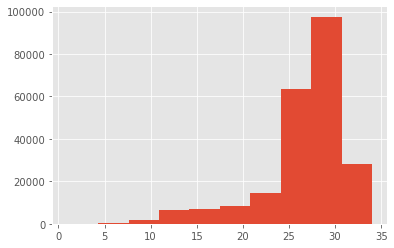

'Number of instances: 227940'

In [25]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.hist(train_features_df.isnull().sum(axis=1), bins=10)
plt.show()

display("Number of instances: {}".format(train_features_df.shape[0]))

In [3]:
labels_sepsis_positive = train_labels_df.loc[train_labels_df['LABEL_Sepsis'] == 1]
display(labels_sepsis_positive.describe())
display(labels_sepsis_positive.head(100))

#temp_grouped = group_columns_in_df(train_features_df)
#display(temp_grouped.head(10))
#features_sepsis_positive = temp_grouped.loc[temp_grouped['pid'].isin(labels_sepsis_positive['pid'])]
#scale_df(features_sepsis_positive)
#display(features_sepsis_positive.describe())

,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
count,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.0,1088.000000,1088.000000,1088.000000,1088.000000
mean,15935.926471,0.547794,0.177390,0.465993,0.460478,0.469669,0.605699,0.129596,0.511949,0.100184,0.189338,1.0,19.881541,80.647059,97.036397,88.546599
std,9166.983876,0.497939,0.382174,0.499072,0.498665,0.499309,0.488925,0.336012,0.500087,0.300383,0.391957,0.0,4.631534,11.236957,2.451813,14.966026
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,51.800000,67.000000,49.800000
25%,8043.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,16.700000,72.800000,95.900000,78.175000
50%,16180.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,19.500000,79.550000,97.400000,87.800000
75%,23941.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,22.500000,88.000000,98.600000,98.325000
max,31515.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,36.900000,125.300000,100.000000,134.700000


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
7,10007,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.8,97.0,94.3,76.0
20,10023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,13.3,80.3,96.7,78.0
25,10030,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,17.9,85.3,99.8,95.2
27,10034,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,16.1,89.2,99.7,65.4
31,10038,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,18.4,62.0,97.1,81.1
35,10048,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,18.4,95.5,97.6,98.6
53,10072,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15.7,78.8,97.6,91.7
83,10116,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,15.8,91.2,99.3,74.9
93,10130,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,20.6,78.2,97.0,101.8
109,10150,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,18.1,72.8,97.9,67.0


## Grouping

* groupby the `'pid'` column values for each age range from `[0, 20, 30, 40, 50, 60, 70, 80, 110]`
* ignore `'Time'` col

In [4]:
def group_columns_in_df(df):
    age_ranges = [0, 20, 30, 40, 50, 60, 70, 80, 110]
    dfs = []
    for i in range(len(age_ranges) - 1):
        age_l = age_ranges[i]
        age_u = age_ranges[i+1]
        sub_df = df[(df['Age'] >= age_l) & (df['Age'] < age_u)]
        sub_df = sub_df.loc[:, sub_df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.median)
        sub_df = sub_df.fillna(sub_df.median())
        dfs.append(sub_df)
    grouped_df = df.loc[:, df.columns != 'Time'].groupby('pid', as_index=False, sort=False).agg(np.nanmedian)
    result = grouped_df.copy()
    result.update(result[['pid']].merge(pd.concat(dfs)))
    result = result.astype({"pid": int})
    assert(grouped_df.shape == result.shape)
    assert(not grouped_df.equals(result))
    return result

X_df = group_columns_in_df(train_features_df)
display(X_df.shape)
display(X_df.head(20))

X_test_df = group_columns_in_df(test_features_df)

(18995, 36)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,34.0,35.00,29.80,12.0,1.800,37.0,8.5,26.0,0.00,18.0,242.0,4.6,4.70,0.500,43.0,36.0,0.40,143.0,98.0,120.00,67.5,1.8,4.100,48.50,7.60,75.0,100.0,0.20,111.0,23.1,75.0,0.8,0.040,111.0,7.370
1,10,71.0,32.00,27.80,12.0,1.900,36.0,14.6,24.0,-0.75,16.0,232.0,2.5,11.50,0.820,40.0,20.0,0.50,207.0,97.0,152.00,101.0,1.5,3.200,82.00,8.60,68.0,98.0,0.23,107.0,42.1,80.0,1.3,0.010,136.0,7.375
2,100,68.0,33.00,20.90,21.0,1.800,36.0,12.5,27.0,-0.50,15.0,238.5,3.5,12.50,1.100,40.0,33.0,0.50,204.0,97.0,243.00,80.0,1.7,3.600,63.00,9.00,71.0,97.0,0.30,101.0,36.8,113.0,0.8,0.155,113.0,7.370
3,1000,79.0,30.00,32.50,22.0,3.855,37.0,9.2,24.0,-0.75,12.0,232.0,1.9,19.60,0.960,44.0,30.0,0.40,158.0,98.0,135.00,82.0,2.0,3.900,63.00,1.17,69.0,100.0,0.23,107.0,27.3,79.0,0.8,0.140,134.0,7.300
4,10000,76.0,32.00,28.55,22.0,1.900,37.0,10.7,25.5,1.50,12.0,232.0,3.4,7.75,1.000,44.0,30.0,0.50,135.0,98.0,121.75,68.0,1.4,3.900,49.50,8.25,69.0,98.0,0.23,103.5,30.3,75.0,0.8,0.140,130.0,7.395
5,10002,73.0,19.00,31.30,18.0,3.005,37.0,10.4,24.0,-0.75,19.5,161.0,3.0,10.30,0.980,40.5,41.0,0.80,83.0,97.0,126.50,66.0,2.1,4.475,48.00,3.12,38.0,100.0,0.23,107.0,30.3,68.0,0.8,0.140,129.0,7.375
6,10006,51.0,33.50,31.30,15.0,1.800,37.5,10.8,24.0,0.00,20.0,234.0,3.5,10.40,0.900,40.5,37.0,0.50,196.0,97.5,200.50,71.0,2.0,4.000,49.00,8.30,75.0,96.0,0.40,106.0,32.3,83.0,0.8,0.095,122.0,7.375
7,10007,60.0,33.00,31.90,17.0,1.800,38.0,10.5,24.0,-0.50,22.0,238.5,2.4,10.40,0.920,40.0,33.0,0.50,195.0,97.0,87.00,114.0,1.6,3.600,91.00,8.20,71.0,94.0,0.30,106.0,31.3,89.0,0.8,0.080,146.0,7.370
8,10009,69.0,33.00,86.05,15.0,1.800,37.0,12.2,21.0,-0.50,23.0,238.5,3.1,8.70,0.500,40.0,17.0,0.50,182.0,97.0,109.00,66.0,1.2,4.100,67.00,8.10,64.0,97.0,0.30,104.0,34.0,98.0,0.8,0.155,90.0,7.370
9,1001,36.0,35.00,31.20,10.0,1.800,38.0,10.4,31.0,8.50,12.0,242.0,2.1,8.70,0.500,36.0,36.0,0.40,205.0,98.0,98.00,85.0,2.0,3.100,69.00,8.50,75.0,100.0,0.20,105.0,29.7,107.0,0.8,0.040,113.0,7.550


## Adding features

In [5]:
def max_abs_diff_agg_fn(x):
    if x.isna().all():
        return 0
    else:
        min_val = np.nanmin(x)
        max_val = np.nanmax(x)
        res = np.abs(max_val - min_val)
        return res

def std_dev_agg_fn(x):
    if x.isna().all():
        return 0
    else:
        return np.nanstd(x)
    
def min_agg_fn(x):
    if x.isna().all():
        return np.nan
    else:
        return np.nanmin(x)
    
def max_agg_fn(x):
    if x.isna().all():
        return np.nan
    else:
        return np.nanmax(x)

def add_features(df_to_group, df_to_add_features_to):
    """Add maximum absolute difference features for each column to a dataframe
    
    Args:
        df_to_group (pd.DataFrame): the dataframe that will be grouped by 'pid'
        df_to_add_features_to (pd.DataFrame): the dataframe to add new features to
        
    Returns:
        pd.DataFrame: the new dataframe with all features
    """
    grouped_df = df_to_group.drop(['Age', 'Time'], axis=1).groupby('pid', as_index=False, sort=False)
    ## Maximum Absolute Difference
    mad_features_df = grouped_df.agg(max_abs_diff_agg_fn)
    mad_features_df.columns = [str(col) + '_diff' for col in mad_features_df.columns]
    # Remove 'pid' col from features_df
    mad_features_df = mad_features_df.iloc[:, 1:]
    
    ## Std dev.
    std_features_df = grouped_df.agg(std_dev_agg_fn)
    std_features_df.columns = [str(col) + '_std' for col in std_features_df.columns]
    # Remove 'pid' col from features_df
    std_features_df = std_features_df.iloc[:, 1:]
    
    ## Min
    min_features_df = grouped_df.agg(min_agg_fn)
    min_features_df.columns = [str(col) + '_min' for col in min_features_df.columns]
    # Remove 'pid' col from features_df
    min_features_df = min_features_df.iloc[:, 1:]
    
    ## Max
    max_features_df = grouped_df.agg(max_agg_fn)
    max_features_df.columns = [str(col) + '_max' for col in max_features_df.columns]
    # Remove 'pid' col from features_df
    max_features_df = max_features_df.iloc[:, 1:]
    
    ## Result
    return pd.concat([df_to_add_features_to, mad_features_df, min_features_df, max_features_df, std_features_df], axis=1, sort=False)

X_df = add_features(train_features_df, X_df)

display(X_df.shape)
display(X_df.describe())
display(X_df.head(30))

X_test_df = add_features(test_features_df, X_test_df)

X_df_backup = X_df.copy()
X_test_df_backup = X_test_df.copy()

(18995, 172)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
count,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,1322.000000,7816.000000,13966.000000,4872.000000,18552.000000,13975.000000,7837.000000,5697.000000,18843.000000,1714.000000,9329.000000,13341.000000,13727.000000,7772.000000,4796.000000,7678.000000,13541.000000,5055.000000,16330.000000,18888.000000,12326.000000,14997.000000,15113.000000,12266.000000,4744.000000,18973.000000,623.000000,8351.000000,14639.000000,18988.000000,4711.000000,2792.000000,18597.000000,7994.000000,1322.000000,7816.000000,13966.000000,4872.000000,18552.000000,13975.000000,7837.000000,5697.000000,18843.000000,1714.000000,9329.000000,13341.000000,13727.000000,7772.000000,4796.000000,7678.000000,13541.000000,5055.000000,16330.000000,18888.000000,12326.000000,14997.000000,15113.000000,12266.000000,4744.000000,18973.000000,623.000000,8351.000000,14639.000000,18988.000000,4711.000000,2792.000000,18597.000000,7994.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,34.0,35.00,29.80,12.0,1.800,37.0,8.50,26.0,0.00,18.0,242.0,4.6,4.70,0.500,43.0,36.0,0.40,143.0,98.0,120.00,67.5,1.8,4.100,48.50,7.60,75.0,100.0,0.20,111.0,23.10,75.0,0.8,0.040,111.0,7.370,0.0,0.0,0.0,0.00,2.0,0.2,2.0,2.0,6.0,0.0,0.0,1.6,0.00,3.0,0.0,0.1,0.0,0.0,0.0,31.0,0.9,0.30,23.50,0.00,0.0,0.0,0.0,3.0,2.4,41.0,0.0,0.00,42.0,0.08,NaN,NaN,12.0,NaN,36.0,8.5,24.0,-2.0,12.0,NaN,4.6,4.7,0.50,42.0,NaN,0.40,143.0,NaN,120.0,53.0,1.2,3.80,39.00,7.60,NaN,100.0,NaN,111.0,22.2,58.0,NaN,NaN,100.0,7.33,NaN,NaN,12.0,NaN,38.0,8.7,26.0,0.0,18.0,NaN,4.6,6.3,0.50,45.0,NaN,0.50,143.0,NaN,120.0,84.0,2.1,4.1,62.5,7.60,NaN,100.0,NaN,114.0,24.6,99.0,NaN,NaN,142.0,7.41,0.000000,0.00,0.000000,0.000,0.661438,0.094281,0.942809,0.942809,1.732051,0.0,0.00000,0.754247,0.00000,1.247219,0.0,4.330127e-02,0.0,0.000000,0.000000,7.961714,0.328634,0.141421,6.799203,0.000000,0.0,0.000000,0.0,1.414214,0.909212,13.325779,0.0,0.000,11.572237,0.028284
1,10,71.0,32.00,27.80,12.0,1.900,36.0,14.60,24.0,-0.75,16.0,232.0,2.5,11.50,0.820,40.0,20.0,0.50,207.0,97.0,152.00,101.0,1.5,3.200,82.00,8.60,68.0,98.0,0.23,107.0,42.10,80.0,1.3,0.010,136.0,7.375,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.00,35.00,0.00,0.0,3.0,0.0,0.0,0.0,19.0,0.0,0.00,39.0,0.00,NaN,27.8,12.0,NaN,36.0,14.6,NaN,NaN,15.0,NaN,2.5,11.5,0.82,NaN,20.0,NaN,207.0,NaN,152.0,83.0,1.5,3.20,64.00,8.60,68.0,96.0,NaN,NaN,42.1,69.0,1.3,0.01,113.0,NaN,NaN,27.8,12.0,NaN,36.0,14.6,NaN,NaN,23.0,NaN,2.5,11.5,0.82,NaN,20.0,NaN,207.0,NaN,152.0,120.0,1.5,3.2,99.0,8.60,68.0,99.0,NaN,NaN,42.1,88.0,1.3,0.01,152.0,NaN,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,3.028787,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000,10.109320,0.000000,0.000000,10.136262,0.000000,0.0,1.044466,0.0,0.000000,0.000000,6.235065,0.0,0.000,11.508531,0.000000
2,100,68.0,33.00,20.90,21.0,1.800,36.0,12.50,27.0,-0.50,15.0,238.5,3.5,12.50,1.100,40.0,33.0,0.50,204.0,97.0,243.00,80.0,1.7,3.600,63.00,9.00,71.0,97.0,0.30,101.0,36.80,113.0,0.8,0.155,113.0,7.370,0.0,0.0,0.0,0.00,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.

In [6]:
X_df = X_df_backup.copy()
X_test_df = X_test_df_backup.copy()

## Data imputation

In [7]:
def median_impute_df(df):
    return df.fillna(df.median())

def impute_min_max_df(df):
    filled_cols = [col for col in X_df if (all([not col.endswith(suffix) for suffix in ['_min', '_max', '_diff', '_std']])) and col != 'pid' and col != 'Age']
    df_filled = df[filled_cols].copy()
    
    min_cols = [col for col in X_df if col.endswith('_min')]
    df_filled.columns = min_cols
    df[min_cols] = df[min_cols].fillna(df_filled)
    
    max_cols = [col for col in X_df if col.endswith('_max')]
    df_filled.columns = max_cols
    df[max_cols] = df[max_cols].fillna(df_filled)
    return df

median_cols = [col for col in X_df if not col.endswith('_max') and not col.endswith('_min')]
display(X_df.head(20))
X_df[median_cols] = median_impute_df(X_df[median_cols].copy())
display(X_df.head(30))
X_df = impute_min_max_df(X_df)
display(X_df.head(30))

median_cols = [col for col in X_test_df if not col.endswith('_max') and not col.endswith('_min')]
X_test_df[median_cols] = median_impute_df(X_test_df[median_cols].copy())
X_test_df = impute_min_max_df(X_test_df)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,34.0,35.00,29.80,12.0,1.800,37.0,8.5,26.0,0.00,18.0,242.0,4.6,4.70,0.500,43.0,36.0,0.40,143.0,98.0,120.00,67.5,1.8,4.100,48.50,7.60,75.0,100.0,0.20,111.0,23.1,75.0,0.8,0.040,111.0,7.370,0.0,0.0,0.0,0.00,2.0,0.2,2.0,2.0,6.0,0.0,0.0,1.6,0.00,3.0,0.0,0.1,0.0,0.0,0.0,31.0,0.9,0.30,23.50,0.00,0.0,0.0,0.0,3.0,2.4,41.0,0.0,0.0,42.0,0.08,NaN,NaN,12.0,NaN,36.0,8.5,24.0,-2.0,12.0,NaN,4.6,4.7,0.50,42.0,NaN,0.40,143.0,NaN,120.0,53.0,1.2,3.80,39.00,7.60,NaN,100.0,NaN,111.0,22.2,58.0,NaN,NaN,100.0,7.33,NaN,NaN,12.0,NaN,38.0,8.7,26.0,0.0,18.0,NaN,4.6,6.3,0.50,45.0,NaN,0.50,143.0,NaN,120.0,84.0,2.1,4.1,62.5,7.60,NaN,100.0,NaN,114.0,24.6,99.0,NaN,NaN,142.0,7.41,0.000000,0.00,0.0,0.000,0.661438,0.094281,0.942809,0.942809,1.732051,0.0,0.0,0.754247,0.000,1.247219,0.0,0.043301,0.0,0.000000,0.000000,7.961714,0.328634,0.141421,6.799203,0.000000,0.0,0.000000,0.0,1.414214,0.909212,13.325779,0.0,0.0,11.572237,0.028284
1,10,71.0,32.00,27.80,12.0,1.900,36.0,14.6,24.0,-0.75,16.0,232.0,2.5,11.50,0.820,40.0,20.0,0.50,207.0,97.0,152.00,101.0,1.5,3.200,82.00,8.60,68.0,98.0,0.23,107.0,42.1,80.0,1.3,0.010,136.0,7.375,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.00,35.00,0.00,0.0,3.0,0.0,0.0,0.0,19.0,0.0,0.0,39.0,0.00,NaN,27.8,12.0,NaN,36.0,14.6,NaN,NaN,15.0,NaN,2.5,11.5,0.82,NaN,20.0,NaN,207.0,NaN,152.0,83.0,1.5,3.20,64.00,8.60,68.0,96.0,NaN,NaN,42.1,69.0,1.3,0.01,113.0,NaN,NaN,27.8,12.0,NaN,36.0,14.6,NaN,NaN,23.0,NaN,2.5,11.5,0.82,NaN,20.0,NaN,207.0,NaN,152.0,120.0,1.5,3.2,99.0,8.60,68.0,99.0,NaN,NaN,42.1,88.0,1.3,0.01,152.0,NaN,0.000000,0.00,0.0,0.000,0.000000,0.000000,0.000000,0.000000,3.028787,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,10.109320,0.000000,0.000000,10.136262,0.000000,0.0,1.044466,0.0,0.000000,0.000000,6.235065,0.0,0.0,11.508531,0.000000
2,100,68.0,33.00,20.90,21.0,1.800,36.0,12.5,27.0,-0.50,15.0,238.5,3.5,12.50,1.100,40.0,33.0,0.50,204.0,97.0,243.00,80.0,1.7,3.600,63.00,9.00,71.0,97.0,0.30,101.0,36.8,113.0,0.8,0.155,113.0,7.370,0.0,0.0,0.0,0.00,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.00,20.00,0.00,0.0,8.0

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,34.0,35.00,29.80,12.0,1.800,37.0,8.50,26.0,0.00,18.0,242.0,4.6,4.70,0.500,43.0,36.0,0.40,143.0,98.0,120.00,67.5,1.8,4.100,48.50,7.60,75.0,100.0,0.20,111.0,23.10,75.0,0.8,0.040,111.0,7.370,0.0,0.0,0.0,0.00,2.0,0.2,2.0,2.0,6.0,0.0,0.0,1.6,0.00,3.0,0.0,0.1,0.0,0.0,0.0,31.0,0.9,0.30,23.50,0.00,0.0,0.0,0.0,3.0,2.4,41.0,0.0,0.00,42.0,0.08,NaN,NaN,12.0,NaN,36.0,8.5,24.0,-2.0,12.0,NaN,4.6,4.7,0.50,42.0,NaN,0.40,143.0,NaN,120.0,53.0,1.2,3.80,39.00,7.60,NaN,100.0,NaN,111.0,22.2,58.0,NaN,NaN,100.0,7.33,NaN,NaN,12.0,NaN,38.0,8.7,26.0,0.0,18.0,NaN,4.6,6.3,0.50,45.0,NaN,0.50,143.0,NaN,120.0,84.0,2.1,4.1,62.5,7.60,NaN,100.0,NaN,114.0,24.6,99.0,NaN,NaN,142.0,7.41,0.000000,0.00,0.000000,0.000,0.661438,0.094281,0.942809,0.942809,1.732051,0.0,0.00000,0.754247,0.00000,1.247219,0.0,4.330127e-02,0.0,0.000000,0.000000,7.961714,0.328634,0.141421,6.799203,0.000000,0.0,0.000000,0.0,1.414214,0.909212,13.325779,0.0,0.000,11.572237,0.028284
1,10,71.0,32.00,27.80,12.0,1.900,36.0,14.60,24.0,-0.75,16.0,232.0,2.5,11.50,0.820,40.0,20.0,0.50,207.0,97.0,152.00,101.0,1.5,3.200,82.00,8.60,68.0,98.0,0.23,107.0,42.10,80.0,1.3,0.010,136.0,7.375,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.00,35.00,0.00,0.0,3.0,0.0,0.0,0.0,19.0,0.0,0.00,39.0,0.00,NaN,27.8,12.0,NaN,36.0,14.6,NaN,NaN,15.0,NaN,2.5,11.5,0.82,NaN,20.0,NaN,207.0,NaN,152.0,83.0,1.5,3.20,64.00,8.60,68.0,96.0,NaN,NaN,42.1,69.0,1.3,0.01,113.0,NaN,NaN,27.8,12.0,NaN,36.0,14.6,NaN,NaN,23.0,NaN,2.5,11.5,0.82,NaN,20.0,NaN,207.0,NaN,152.0,120.0,1.5,3.2,99.0,8.60,68.0,99.0,NaN,NaN,42.1,88.0,1.3,0.01,152.0,NaN,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,3.028787,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000,10.109320,0.000000,0.000000,10.136262,0.000000,0.0,1.044466,0.0,0.000000,0.000000,6.235065,0.0,0.000,11.508531,0.000000
2,100,68.0,33.00,20.90,21.0,1.800,36.0,12.50,27.0,-0.50,15.0,238.5,3.5,12.50,1.100,40.0,33.0,0.50,204.0,97.0,243.00,80.0,1.7,3.600,63.00,9.00,71.0,97.0,0.30,101.0,36.80,113.0,0.8,0.155,113.0,7.370,0.0,0.0,0.0,0.00,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,34.0,35.00,29.80,12.0,1.800,37.0,8.50,26.0,0.00,18.0,242.0,4.6,4.70,0.500,43.0,36.0,0.40,143.0,98.0,120.00,67.5,1.8,4.100,48.50,7.60,75.0,100.0,0.20,111.0,23.10,75.0,0.8,0.040,111.0,7.370,0.0,0.0,0.0,0.00,2.0,0.2,2.0,2.0,6.0,0.0,0.0,1.6,0.00,3.0,0.0,0.1,0.0,0.0,0.0,31.0,0.9,0.30,23.50,0.00,0.0,0.0,0.0,3.0,2.4,41.0,0.0,0.00,42.0,0.08,35.00,29.8,12.0,1.80,36.0,8.5,24.0,-2.00,12.0,242.0,4.6,4.7,0.50,42.0,36.0,0.40,143.0,98.0,120.0,53.0,1.2,3.80,39.00,7.60,75.0,100.0,0.20,111.0,22.2,58.0,0.8,0.040,100.0,7.330,35.00,29.8,12.0,1.80,38.0,8.7,26.0,0.00,18.0,242.0,4.6,6.3,0.50,45.0,36.0,0.50,143.0,98.0,120.0,84.0,2.1,4.1,62.50,7.60,75.0,100.0,0.20,114.0,24.6,99.0,0.8,0.040,142.0,7.410,0.000000,0.00,0.000000,0.000,0.661438,0.094281,0.942809,0.942809,1.732051,0.0,0.00000,0.754247,0.00000,1.247219,0.0,4.330127e-02,0.0,0.000000,0.000000,7.961714,0.328634,0.141421,6.799203,0.000000,0.0,0.000000,0.0,1.414214,0.909212,13.325779,0.0,0.000,11.572237,0.028284
1,10,71.0,32.00,27.80,12.0,1.900,36.0,14.60,24.0,-0.75,16.0,232.0,2.5,11.50,0.820,40.0,20.0,0.50,207.0,97.0,152.00,101.0,1.5,3.200,82.00,8.60,68.0,98.0,0.23,107.0,42.10,80.0,1.3,0.010,136.0,7.375,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.00,35.00,0.00,0.0,3.0,0.0,0.0,0.0,19.0,0.0,0.00,39.0,0.00,32.00,27.8,12.0,1.90,36.0,14.6,24.0,-0.75,15.0,232.0,2.5,11.5,0.82,40.0,20.0,0.50,207.0,97.0,152.0,83.0,1.5,3.20,64.00,8.60,68.0,96.0,0.23,107.0,42.1,69.0,1.3,0.010,113.0,7.375,32.00,27.8,12.0,1.90,36.0,14.6,24.0,-0.75,23.0,232.0,2.5,11.5,0.82,40.0,20.0,0.50,207.0,97.0,152.0,120.0,1.5,3.2,99.00,8.60,68.0,99.0,0.23,107.0,42.1,88.0,1.3,0.010,152.0,7.375,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,3.028787,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000,10.109320,0.000000,0.000000,10.136262,0.000000,0.0,1.044466,0.0,0.000000,0.000000,6.235065,0.0,0.000,11.508531,0.000000
2,100,68.0,33.00,20.90,21.0,1.800,36.0,12.50,27.0,-0.50,15.0,238.5,3.5,12.50,1.100,40.0,33.0,0.50,204.0,97.0,243.00,80.0,1.7,3.600,63.00,9.00,71.0,97.0,0.30,101.0,36.80,113.0,0.8,0.155,113.0,7.370,0.0,

## Scaling / normalization

In [8]:
from sklearn import preprocessing

# Scale the dataframe
def scale_df(df):
    scaler = preprocessing.MinMaxScaler()
    df.loc[:, df.columns != 'pid'] = scaler.fit_transform(df.loc[:, df.columns != 'pid'])

scale_df(X_df)
display(X_df.describe())
display(X_df.head(30))

scale_df(X_test_df)

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
count,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.000000,18995.00000,18995.000000,18995.000000,18995.000000,18995.000000,1899

,pid,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH,EtCO2_diff,PTT_diff,BUN_diff,Lactate_diff,Temp_diff,Hgb_diff,HCO3_diff,BaseExcess_diff,RRate_diff,Fibrinogen_diff,Phosphate_diff,WBC_diff,Creatinine_diff,PaCO2_diff,AST_diff,FiO2_diff,Platelets_diff,SaO2_diff,Glucose_diff,ABPm_diff,Magnesium_diff,Potassium_diff,ABPd_diff,Calcium_diff,Alkalinephos_diff,SpO2_diff,Bilirubin_direct_diff,Chloride_diff,Hct_diff,Heartrate_diff,Bilirubin_total_diff,TroponinI_diff,ABPs_diff,pH_diff,EtCO2_min,PTT_min,BUN_min,Lactate_min,Temp_min,Hgb_min,HCO3_min,BaseExcess_min,RRate_min,Fibrinogen_min,Phosphate_min,WBC_min,Creatinine_min,PaCO2_min,AST_min,FiO2_min,Platelets_min,SaO2_min,Glucose_min,ABPm_min,Magnesium_min,Potassium_min,ABPd_min,Calcium_min,Alkalinephos_min,SpO2_min,Bilirubin_direct_min,Chloride_min,Hct_min,Heartrate_min,Bilirubin_total_min,TroponinI_min,ABPs_min,pH_min,EtCO2_max,PTT_max,BUN_max,Lactate_max,Temp_max,Hgb_max,HCO3_max,BaseExcess_max,RRate_max,Fibrinogen_max,Phosphate_max,WBC_max,Creatinine_max,PaCO2_max,AST_max,FiO2_max,Platelets_max,SaO2_max,Glucose_max,ABPm_max,Magnesium_max,Potassium_max,ABPd_max,Calcium_max,Alkalinephos_max,SpO2_max,Bilirubin_direct_max,Chloride_max,Hct_max,Heartrate_max,Bilirubin_total_max,TroponinI_max,ABPs_max,pH_max,EtCO2_std,PTT_std,BUN_std,Lactate_std,Temp_std,Hgb_std,HCO3_std,BaseExcess_std,RRate_std,Fibrinogen_std,Phosphate_std,WBC_std,Creatinine_std,PaCO2_std,AST_std,FiO2_std,Platelets_std,SaO2_std,Glucose_std,ABPm_std,Magnesium_std,Potassium_std,ABPd_std,Calcium_std,Alkalinephos_std,SpO2_std,Bilirubin_direct_std,Chloride_std,Hct_std,Heartrate_std,Bilirubin_total_std,TroponinI_std,ABPs_std,pH_std
0,1,0.223529,0.277778,0.055341,0.041199,0.064655,0.50,0.250000,0.448276,0.490196,0.178010,0.198847,0.26250,0.011889,0.009569,0.379310,0.003194,0.200,0.059965,0.969231,0.130575,0.296667,0.203125,0.244318,0.157360,0.336735,0.016488,1.000000,0.008966,0.555556,0.240339,0.352518,0.015086,0.000068,0.405714,0.61250,0.000000,0.000000,0.000,0.000000,0.1250,0.018349,0.068966,0.018519,0.086957,0.0,0.000000,0.013104,0.000000,0.045455,0.000000,0.000025,0.000000,0.000000,0.000000,0.133621,0.101124,0.048309,0.095142,0.000000,0.000000,0.000000,0.0,0.078947,0.077170,0.325397,0.000000,0.000000,0.237288,0.133333,0.277778,0.072842,0.041199,0.072072,0.75,0.253659,0.48,0.540,0.115789,0.199616,0.271605,0.011889,0.009569,0.367816,0.003194,0.200,0.060776,0.973684,0.143639,0.261905,0.118644,0.264550,0.1900,0.336735,0.016488,1.0000,0.008966,0.616438,0.237037,0.271318,0.015086,0.000068,0.446328,0.607143,0.277778,0.055341,0.041199,0.048860,0.6,0.256158,0.441860,0.200,0.177083,0.180944,0.26250,0.014094,0.009569,0.388889,0.003114,0.000125,0.059965,0.969231,0.108253,0.142857,0.175824,0.231214,0.124535,0.336735,0.016488,1.000000,0.008966,0.564516,0.259542,0.435583,0.015086,0.000068,0.385593,0.588889,0.000000,0.000000,0.000000,0.000000,0.129099,0.017299,0.070143,0.020655,0.088850,0.0,0.000000,0.012355,0.000000,0.045353,0.000000,2.500250e-05,0.000000,0.000000,0.000000,0.114125,0.095225,0.051426,0.093082,0.000000,0.000000,0.000000,0.0,0.074432,0.058470,0.253606,0.000000,0.000000,0.214718,0.111494
1,10,0.658824,0.244444,0.046761,0.041199,0.068966,0.40,0.549020,0.402299,0.475490,0.157068,0.189241,0.13125,0.029465,0.017225,0.344828,0.001546,0.250,0.087575,0.953846,0.171946,0.520000,0.156250,0.142045,0.384095,0.387755,0.014656,0.972603,0.010382,0.492063,0.598492,0.388489,0.025862,0.000000,0.548571,0.61875,0.000000,0.000000,0.000,0.000000,0.0000,0.000000,0.000000,0.000000,0.115942,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.159483,0.000000,0.000000,0.141700,0.000000,0.000000,0.038462,0.0,0.000000,0.000000,0.150794,0.000000,0.000000,0.220339,0.000000,0.244444,0.064421,0.041199,0.076577,0.75

# SVM Training

In [9]:
#X_df = X_df.iloc[0:2000, :]
#train_labels_df = train_labels_df.iloc[0:2000, :]

# Prepare train set
# Assert that the pids are matching in train features / train labels dfs
assert(X_df.iloc[:, 0].astype(int).equals(train_labels_df.iloc[:, 0].astype(int)))

X = X_df.iloc[:, 1:].to_numpy()
y = train_labels_df.iloc[:, 1:].to_numpy()

assert(X.shape[0] == y.shape[0])

In [10]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

model = MultiOutputRegressor(SVR(verbose=True, C=1, epsilon=0.01), n_jobs=-1)

model.fit(X, y)

MultiOutputRegressor(estimator=SVR(C=1, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.01, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=True),
                     n_jobs=-1)

# Predictions

In [11]:
def predict(df):
    # Create X_predict by removing 'pid' column
    X_predict = df.iloc[:, 1:].to_numpy()
    
    # Predict
    predictions = model.predict(X_predict)
    predictions[:, :-4] = np.divide(1, 1+np.exp(-predictions[:, :-4]))
    
    # Create predictions df
    predict_labels_df = pd.DataFrame(columns=train_labels_df.columns)
    predict_labels_df[['pid']] = df[['pid']]
    predict_labels_df.loc[:, predict_labels_df.columns != 'pid'] = predictions
    
    return predict_labels_df

## Train set

In [12]:
prediction_labels_df = predict(X_df)

print(prediction_labels_df.shape)
display(prediction_labels_df.head(15))
display(train_labels_df.head(15))

(18995, 16)


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,0.617072,0.500724,0.498585,0.498643,0.498327,0.505642,0.501113,0.505056,0.499693,0.498614,0.502563,16.923543,73.507130,98.668542,79.518070
1,10,0.502297,0.501084,0.506463,0.506743,0.506672,0.501275,0.502171,0.501506,0.500650,0.502068,0.502470,17.991558,94.831566,97.019223,78.590285
2,100,0.501662,0.501192,0.502044,0.502006,0.502133,0.500296,0.502256,0.500915,0.502205,0.500185,0.502322,17.361333,82.412987,96.577497,101.249073
3,1000,0.476800,0.500817,0.499567,0.499631,0.499587,0.555863,0.501814,0.512636,0.498996,0.684175,0.502038,16.580355,85.823712,97.571588,85.685216
4,10000,0.639169,0.500936,0.499853,0.499825,0.499992,0.499281,0.501253,0.527564,0.499802,0.499456,0.502167,15.681102,72.431557,97.380290,77.167841
5,10002,0.552640,0.502506,0.500475,0.499813,0.499954,0.609800,0.502023,0.510211,0.500199,0.514779,0.502199,19.532506,74.403706,97.104474,74.556661
6,10006,0.502004,0.501845,0.502496,0.502452,0.502379,0.500861,0.502307,0.500346,0.502093,0.500252,0.502448,18.947081,74.475706,96.345553,80.884445
7,10007,0.501446,0.501195,0.503149,0.503302,0.502984,0.501436,0.502273,0.501205,0.501405,0.501183,0.502510,19.702191,101.488845,96.131156,78.395185
8,10009,0.507187,0.501214,0.500726,0.500822,0.501315,0.501565,0.501254,0.502423,0.501079,0.498349,0.502006,20.310834,69.494210,96.706053,92.239179
9,1001,0.790611,0.499936,0.498576,0.498875,0.499070,0.529963,0.501175,0.547597,0.499487,0.500944,0.502133,16.800629,82.203645,98.575838,100.447921


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5
2,100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.5,88.3,96.5,108.1
3,1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,19.4,77.2,98.3,80.9
4,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,76.8,97.7,95.3
5,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,67.4,99.1,64.6
6,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.2,84.9,96.8,90.5
7,10007,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.8,97.0,94.3,76.0
8,10009,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,18.9,72.0,95.3,91.5
9,1001,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.9,83.3,99.9,117.3


In [13]:
prediction_labels_df.to_csv('data/prediction_train.csv', index=False, float_format='%.3f')

In [14]:
train_labels_df.to_csv('data/prediction_gold.csv', index=False, float_format='%.3f')

## Test set

In [15]:
prediction_test_labels_df = predict(X_test_df)

print(prediction_test_labels_df.shape)
display(prediction_test_labels_df.head(15))

(12664, 16)


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,0,0.738512,0.569966,0.824046,0.825192,0.826028,0.544155,0.498869,0.504918,0.505426,0.494088,0.500327,18.066004,88.701434,99.234500,83.287222
1,10001,0.548875,0.504746,0.510910,0.511639,0.511026,0.504110,0.503005,0.503302,0.501565,0.498718,0.502582,23.795548,95.452017,94.885908,99.992107
2,10003,0.607809,0.502027,0.500266,0.500727,0.500485,0.460893,0.502209,0.487780,0.501956,0.493478,0.502047,22.274099,86.154772,98.374613,89.741969
3,10004,0.547778,0.503471,0.507511,0.509628,0.508690,0.502387,0.502288,0.502158,0.502225,0.497999,0.502439,21.211428,77.898680,96.102187,86.438785
4,10005,0.543047,0.502865,0.509847,0.509833,0.509481,0.500283,0.502808,0.505864,0.502779,0.498819,0.502266,25.166275,80.921469,96.429741,59.578915
5,10008,0.661471,0.504044,0.523822,0.524359,0.524201,0.562592,0.502229,0.496727,0.502549,0.497968,0.501659,24.141046,98.792709,97.797850,72.488332
6,10011,0.545684,0.506818,0.510043,0.510595,0.509845,0.503504,0.502717,0.507340,0.501862,0.498909,0.502266,20.941755,103.185115,98.619579,70.132251
7,10017,0.549443,0.504746,0.504710,0.505677,0.504793,0.510089,0.502789,0.498468,0.500131,0.499320,0.502777,26.999101,113.560567,97.806052,98.161894
8,10018,0.546033,0.503757,0.511318,0.512185,0.511262,0.499875,0.503086,0.510909,0.501347,0.550939,0.502395,24.109467,83.588424,94.976626,99.102896
9,10019,0.648404,0.502140,0.507136,0.508014,0.507206,0.478312,0.502194,0.704489,0.499870,0.498406,0.501318,22.195203,85.456386,96.238367,74.380832


In [16]:
prediction_test_labels_df.to_csv('data/prediction.csv', index=False, float_format='%.3f')

# Per label SVM experiments

In [20]:
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

heartrate_model = SVR(verbose=True, C=1, epsilon=0.005)
#heartrate_model = Ridge(alpha=1.0)
#heartrate_model = MLPRegressor(max_iter=50, hidden_layer_sizes=(200, 50), verbose=True)

from itertools import chain, combinations

def powerset(iterable):
    "list(powerset([1,2,3])) --> [(), (1,), (2,), (3,), (1,2), (1,3), (2,3), (1,2,3)]"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

feature_columns = X_df.iloc[:, 1:4].columns
feature_col_powerset = powerset(feature_columns)
feature_col_powerset.remove(())

main_features = ['Heartrate', 'Temp', 'RRate', 'Bilirubin_direct',
       'WBC', 'ABPd', 'Chloride', 'Fibrinogen']
all_features = main_features + ['{}_diff'.format(a) for a in main_features] + ['Heartrate_std', 'Temp_std', 'RRate_std']
X_heartrate = X_df.iloc[:, 1:].to_numpy()
y_heartrate = train_labels_df.iloc[:, 1:][['LABEL_Heartrate']].to_numpy().ravel()

print(X_heartrate.shape, y_heartrate.shape)

heartrate_model.fit(X_heartrate, y_heartrate)

(18995, 171) (18995,)
[LibSVM]

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [21]:
def predict_label(mdl, label, X_predict):
    # Predict
    predictions = mdl.predict(X_predict)
    col_idx = train_labels_df.columns.get_loc(label)
    display(predictions.shape, np.zeros(train_labels_df.iloc[:, 1:].shape).shape, col_idx)
    # Create predictions df
    predict_labels_df = pd.DataFrame(data=np.zeros(train_labels_df.shape), columns=train_labels_df.columns)
    predict_labels_df[['pid']] = train_labels_df[['pid']]
    predict_labels_df.iloc[:, col_idx] = predictions
    
    return predict_labels_df

In [22]:
label = 'LABEL_Heartrate'
label_predictions_df = predict_label(heartrate_model, label, X_heartrate)

print(label_predictions_df.shape)
display(label_predictions_df.head(15))
display(train_labels_df.head(15))

label_predictions_df.to_csv('data/prediction_{}.csv'.format(label), index=False, float_format='%.3f')

(18995,)

(18995, 15)

15

(18995, 16)


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.516820
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.590926
2,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.252799
3,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.686020
4,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.175034
5,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.568123
6,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.890328
7,10007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.389455
8,10009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.240728
9,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.457761


,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5
2,100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.5,88.3,96.5,108.1
3,1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,19.4,77.2,98.3,80.9
4,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,76.8,97.7,95.3
5,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,67.4,99.1,64.6
6,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.2,84.9,96.8,90.5
7,10007,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.8,97.0,94.3,76.0
8,10009,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,18.9,72.0,95.3,91.5
9,1001,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.9,83.3,99.9,117.3
